## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import glob
import time
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import isuelogit as isl

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import data_curation, add_period_id

# Functions from internal modules
from nesuelogit.models import compute_generated_trips, compute_generation_factors,  \
    create_tvodlulpe_model_fresno, create_tvgodlulpe_model_fresno, compute_benchmark_metrics
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import  plot_predictive_performance, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, \
    plot_convergence_estimates, plot_parameters, plot_relative_gap_by_period, plot_congestion_maps
from nesuelogit.metrics import mse, mape, mdape, r2_score, z2score
from nesuelogit.utils import read_paths, load_k_shortest_paths, flat_od_from_generated_trips

### Hyperparameters and configurations

In [5]:
# Data
_DAYSOFWEEK = [1,2,3] # Monday:0, Sunday:6
_HOURS = np.arange(6,21)
# _HOURS = [6,7,8, 15,16,17]

# Loss function
_LOSS_WEIGHTS = {'tvodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
                 'tvgodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}}
_LOSS_METRIC  = z2score

# Optimization
_BATCH_SIZE = 1
_LR = {'tvodlulpe': {'learning': 5e-2, 'equilibrium': 5e-2},
       'tvgodlulpe': {'learning': 5e-2, 'equilibrium': 5e-2, 'generation': 10}}
_EPOCHS = {'tvodlulpe':{'learning': 20, 'equilibrium': 0},
           'tvgodlulpe':{'learning': 15, 'equilibrium': 0}}
_OPTIMIZERS = {model: {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr)
                       for key, lr in lrs.items()} for model, lrs in _LR.items()}

# Evaluation metric reported during model training
_EVALUATION_METRIC = mape

# Equilibrium condition (if different than 'inf', equilibrium 'epochs' must be greater than 0)
_RELATIVE_GAP = float('inf')

# Exogenous attributes in utility function
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

# Numeric type of tensors
_DTYPE = tf.float32

In [6]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

# To report global runtime
t0_global = time.time()

# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231220120053


## Read node and link level data

In [7]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

## Build network

In [8]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

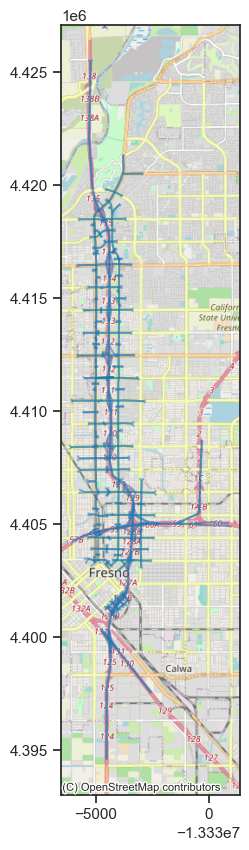

In [9]:
# Display network
fig, ax = plt.subplots(figsize=(10, 10))
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
links_gdf.to_crs(epsg=3857).plot(alpha=0.5, ax = ax)
ctx.add_basemap(ax = ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Read and load OD matrix

In [10]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read and load paths

In [11]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')

#To generate K shortest paths and write in disk
# _K = 3
# load_k_shortest_paths(network=network, k=_K, theta = {'tt':-1}, update_incidence_matrices=True, block_output=False)
# write_paths(network.paths, filepath=f'input/network-data/fresno/paths/paths-fresno-k{_K}.csv')

20840 paths were read and incidence matrices were built


## Read and process spatio-temporal link-level data

In [12]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
# Select data from Tuesday (1) to Thursday (3)
df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]
# Select data from one day only in 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

# # Select countdata from selected links
# selected_links = [(290,169,'0'),(170,168,'0'),(337,692,'0'),(228,192,'0'),(191,171,'0'),(188,87,'0'), (171,290,'0'),(192,191,'0'),(87,228,'0'),(169,332,'0'),(631,635,'0'),(179,183,'0'), (641,86,'0'),(638,634,'0'),(170,207,'0'),(86,189,'0'),(580,142,'0'),(333,332,'0'), (99,43,'0'),(637,639,'0')]
# df.loc[~df.link_key.isin(selected_links),'counts'] = float('nan')
# df.loc[~df.link_key.isin([(290,169,'0')]),'counts'] = float('nan')

In [13]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_inc,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period
0,"(0, 1621, 0)",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,93.828,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10
1,"(1239, 1630, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10
2,"(228, 192, 0)",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,37.414,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10
3,"(1243, 1631, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10
4,"(1244, 1632, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10


In [14]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period'],
      dtype='object')

In [15]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [16]:
# Curation of travel time data
df.loc[df['speed_ref_avg']<=0,'speed_ref_avg'] = float('nan')

df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

In [17]:
# Observed counts as used as a measure of how congested are the links, thus, they are normalized by link capacity
df = pd.merge(df, df.groupby('link_key')[['counts']].max().rename(columns ={'counts':'counts_max'}), on = 'link_key')
df['counts']= df['counts']/df['counts_max']*df['k']

In [18]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd_adj']
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [19]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

## Process node-level data

In [20]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Exploratory Data Analysis

In [21]:
df[['speed_ref_avg','speed_hist_avg','speed_max', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,speed_max,tt_ff,tt_avg,tt_sd_adj
count,599370.000000,1.009583e+06,1.013460e+06,1.013460e+06,887813.000000,1.013460e+06
mean,32.540388,1.767589e+01,2.051278e+01,2.038423e-01,0.219493,3.022799e-04
std,15.223625,1.909664e+01,2.140424e+01,2.610045e-01,0.262030,4.638521e-04
min,8.078000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,24.233000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,26.719000,1.755400e+01,2.112700e+01,1.497376e-01,0.167050,1.856268e-04
75%,32.933000,2.547600e+01,3.106900e+01,2.792397e-01,0.312986,4.248116e-04
max,67.729000,7.891400e+01,8.388500e+01,4.220601e+00,3.827439,1.243267e-02


In [22]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1488.711817,0.204903,0.221931,0.200169,0.018137
std,462.285984,0.262226,0.266852,0.228208,0.027831
min,0.779896,0.000000,0.000000,0.000000,0.000000
25%,1188.724832,0.000000,0.000000,0.000000,0.000000
50%,1494.280386,0.150455,0.168820,0.152000,0.011138
75%,1823.017903,0.282111,0.318261,0.280000,0.025489
max,2400.000000,4.220601,3.827439,2.302000,0.745960


In [23]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1351.644684,0.202618,0.216770,0.198494,0.018137
std,450.202278,0.259583,0.256512,0.226003,0.027831
min,5.725646,0.000000,0.000000,0.000000,0.000000
25%,1038.280415,0.000000,0.000000,0.000000,0.000000
50%,1347.643221,0.149437,0.165341,0.150000,0.011138
75%,1681.922253,0.274658,0.306717,0.273000,0.025489
max,2400.000000,4.220601,3.274444,2.113000,0.745960


In [24]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = df.groupby('date')['hour'].count())

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1497.588808,36195
2019-10-02,1.760109,17.169768,1476.571607,36195
2019-10-03,1.754288,17.092304,1509.584533,36195
2019-10-08,1.847060,18.165569,1478.300459,36195
2019-10-09,1.917923,18.137042,1481.272743,36195
2019-10-10,1.830232,18.107925,1514.981758,36195
2019-10-15,1.831527,18.114384,1480.838248,36195
2019-10-16,1.823680,18.162625,1486.702565,36195
2019-10-17,1.832219,18.080860,1501.029287,36195


In [25]:
## Link-level attributes in utility function
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [26]:
# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z,
                             links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

### Reference O-D matrix and trip generation vectors

In [27]:

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Adjust historic O-D and historic trip generation

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
# growth_factor = 7.9/6.6
# reference_g = growth_factor*reference_g
# reference_q = growth_factor*reference_q

## Models

In [28]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

### TVGODLULPE

In [ ]:
print('\ntvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

models['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                      reference_g = reference_g, reference_q = reference_q, dtype = _DTYPE)

train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS['tvgodlulpe'],
    batch_size=_BATCH_SIZE,
    loss_weights= _LOSS_WEIGHTS['tvgodlulpe'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['tvgodlulpe'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(f"output/models/{ts}_fresno_tvgodlulpe.h5")


tvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions

Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 6 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 7 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 8 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 9 -> p-values kappa:

In [29]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['tvgodlulpe'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                     mape    mdape      mse        r2
component   dataset                                        
equilibrium training   1.92e+05 3.48e-05    6e+04     0.932
            validation 7.38e+16 4.79e-05    3e+04     0.966
flow        benchmark      67.7     30.3 5.77e+05    -0.044
            training       89.5     62.1 2.29e+06     -2.73
            validation     92.3     63.9 2.44e+06     -3.28
traveltime  benchmark      55.7     40.3   0.0658 -0.000404
            training        143     38.4     6.24     -88.3
            validation      146     38.7     5.91     -91.3


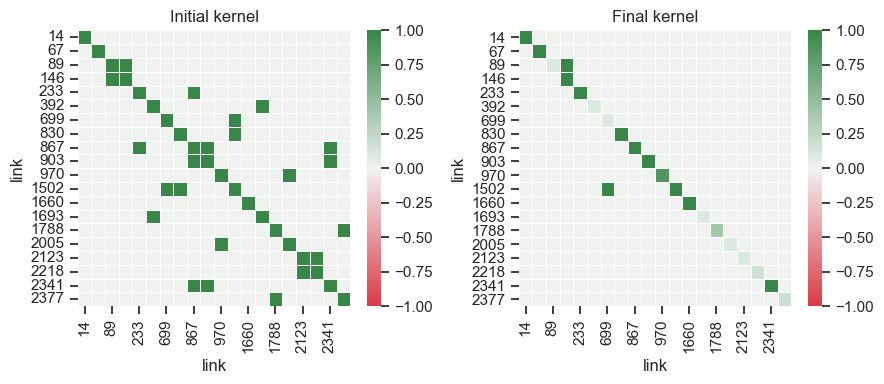

Final weights interaction:
 [[ 1.0365  0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.1     0.     ...  0.      0.      0.    ]
 [ 0.      7.963  10.     ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.6385  0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.1     0.    ]
 [ 0.      0.      0.     ...  0.      0.      1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [29]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

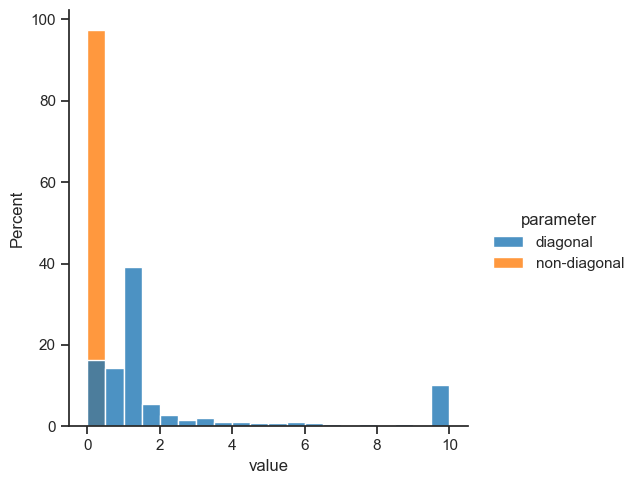

                 value  value_abs
parameter                        
diagonal      2.310261   2.310261
non-diagonal  0.084638   0.084638
              value
parameter          
diagonal       2413
non-diagonal  12314


In [30]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"
    plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [31]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.1316 0.1557 0.2209]


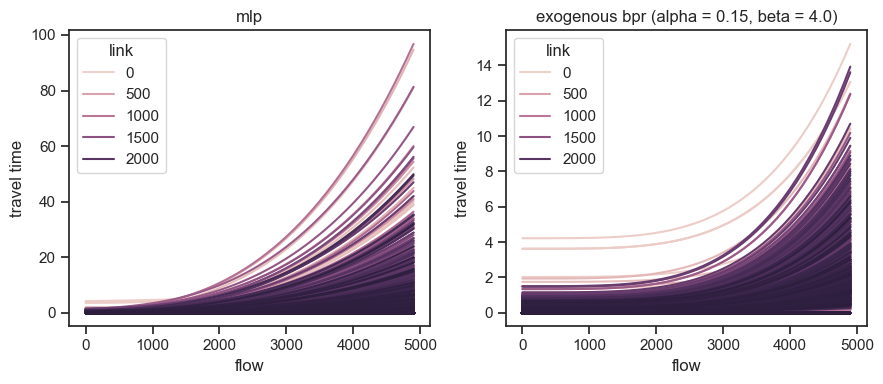

In [32]:
flow_range = range(0,5000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = False,
                           alpha= 0.15,
                           beta= 4,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

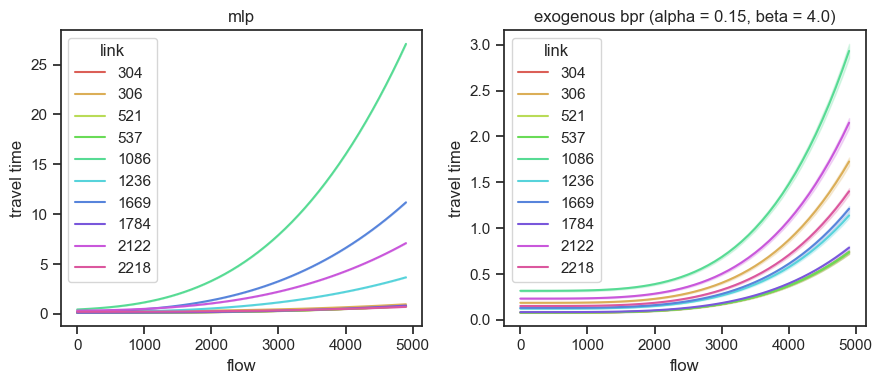

In [33]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

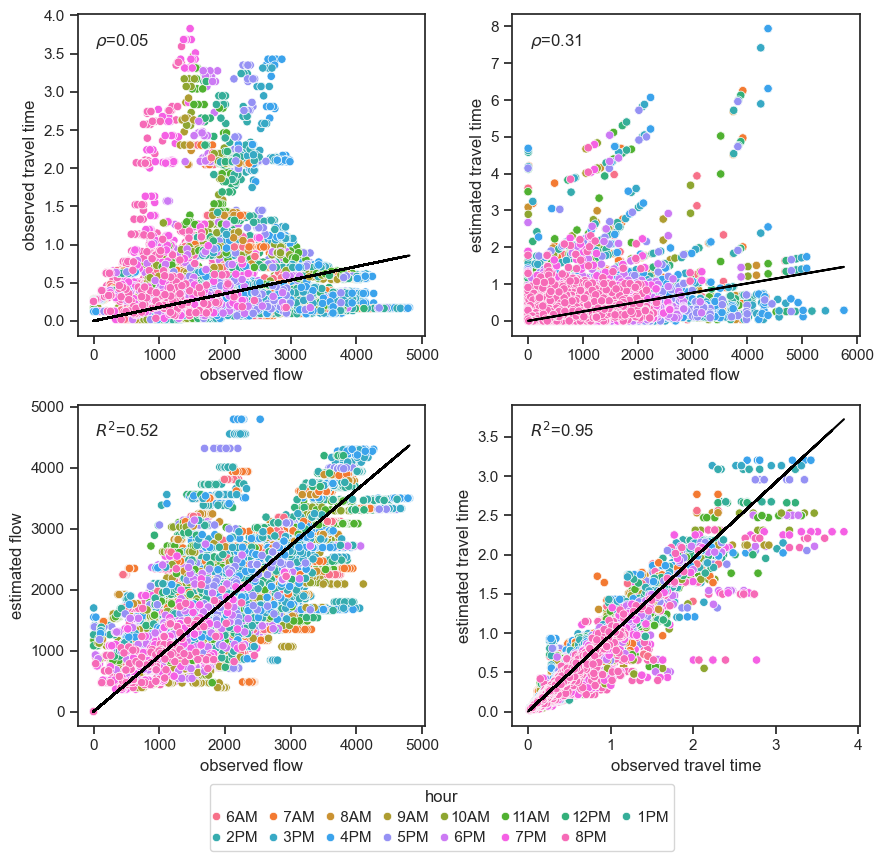

In [34]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

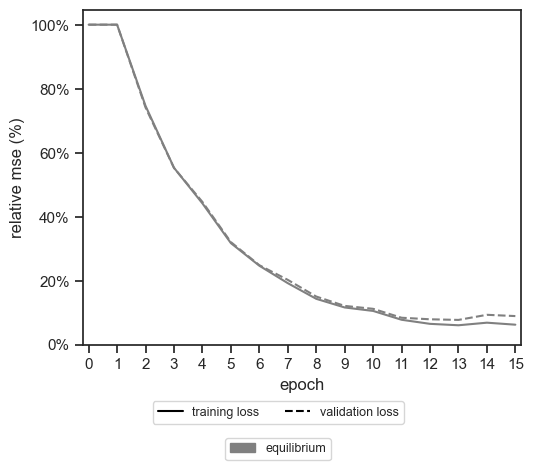

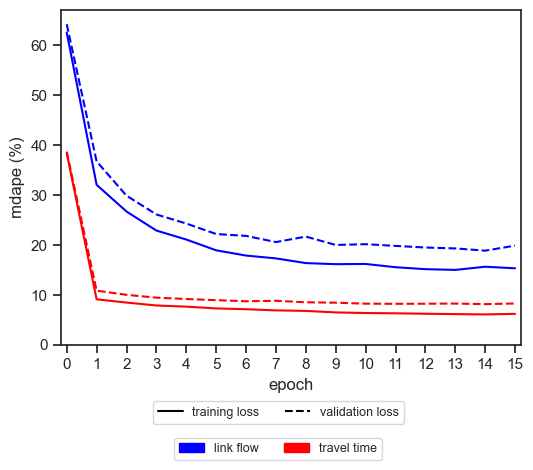

In [35]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['equilibrium'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['travel time', 'link flow'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

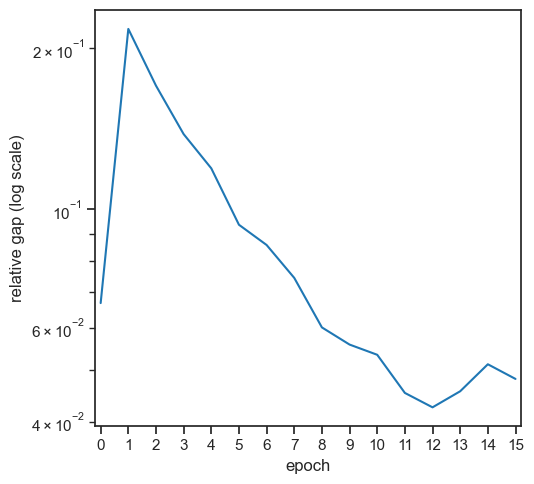

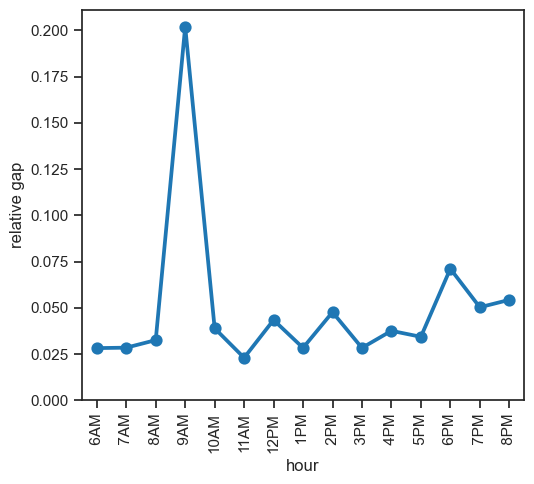

In [36]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

plot_relative_gap_by_period(model = models['tvgodlulpe'], period_keys = period_keys)

plt.savefig('output/figures/results/fresno-relative-gap-period-tvgodlulpe.png')

plt.show()

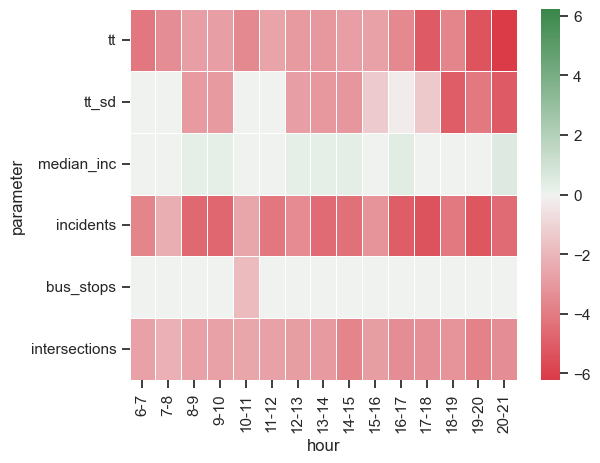

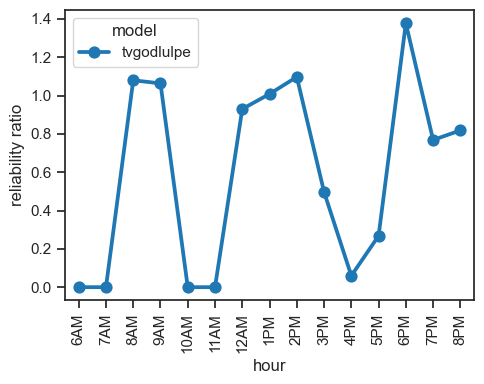

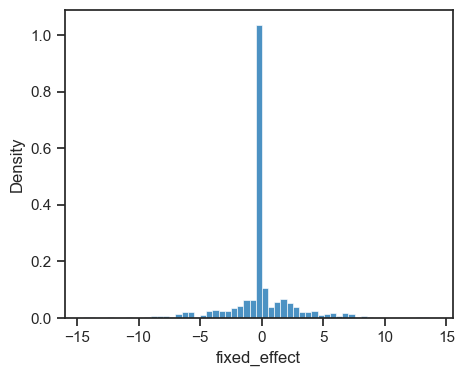

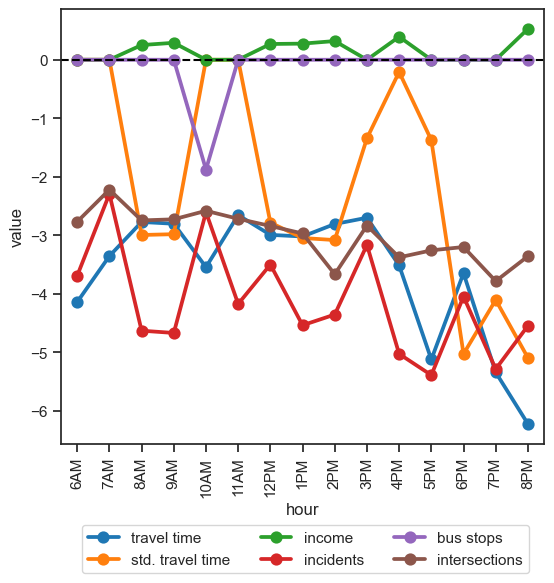

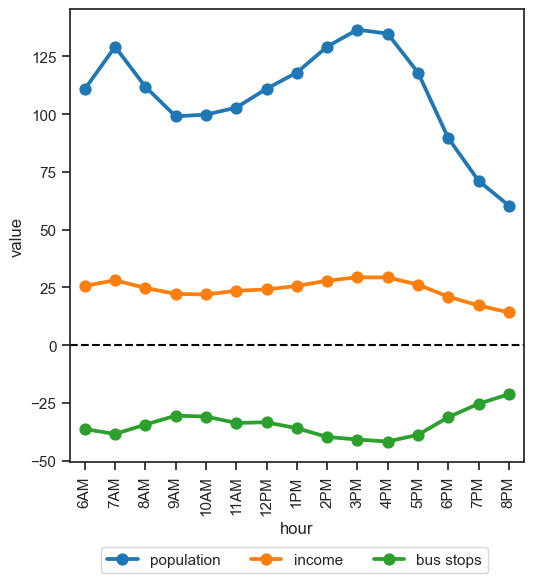

Theta: [[-4.1411 -3.3555 -2.7728 -2.8032 -3.5449 -2.6547 -2.9932 -3.021  -2.8079
  -2.7003 -3.5156 -5.1231 -3.6487 -5.3436 -6.2242]
 [ 0.      0.     -2.9953 -2.9817  0.      0.     -2.7841 -3.0469 -3.082
  -1.3423 -0.2092 -1.3737 -5.0281 -4.1056 -5.0942]
 [ 0.      0.      0.2513  0.2899  0.      0.      0.2694  0.2756  0.3197
   0.      0.3932  0.      0.      0.      0.5272]
 [-3.6912 -2.2931 -4.6311 -4.6699 -2.6058 -4.174  -3.5006 -4.5383 -4.3552
  -3.1655 -5.028  -5.3906 -4.047  -5.2875 -4.5475]
 [ 0.      0.      0.      0.     -1.8771  0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [-2.7687 -2.2208 -2.7464 -2.7274 -2.5818 -2.7185 -2.8414 -2.9697 -3.6668
  -2.8343 -3.3773 -3.2581 -3.2005 -3.7841 -3.3587]]
Kappa: [[110.7568 129.1216 111.832   99.0147  99.768  102.7748 110.9459 117.9624
  129.1474 136.5228 134.7841 117.9568  89.5916  71.1321  60.417 ]
 [ 25.6655  28.0931  24.7819  22.2075  21.9441  23.5535  24.14    25.6158
   27.9302  29.3669  29.32

In [37]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour', rotation_xticks = 90)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvgodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (5.7,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:879: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od         6AM          7AM         8AM         9AM  \
 1618 175     1840.4001   78.398483    31.321568  141.667740   50.185406   
      694     1182.4533   59.543438    29.032598  121.662758  124.245071   
 42   1617    1139.6952  773.759033  1493.395874  773.996155  634.531189   
 693  1617    1077.8859  173.755966    42.024387   27.228714   27.366343   
 272  1614     598.5315    0.248310     2.402628    0.408605    0.169991   
 701  1629     577.9746    6.543324    13.339276    8.446630    7.461898   
 226  1651     472.3362    1.163885     2.957330    1.697659    1.536297   
 220  1688     446.1534    0.979889     3.171143    1.570676    1.159081   
 104  1693     430.1766    0.513942     1.642905    0.852777    0.817262   
 871  1679     428.9796    1.807284     2.097271    1.151155    0.912847   
 1615 88       426.7179    0.000000     0.000000    0.000000    0.000000   
 807  1650     418.2822    2.925624     6.364574    4.435876    3.696963   
 752  1633  

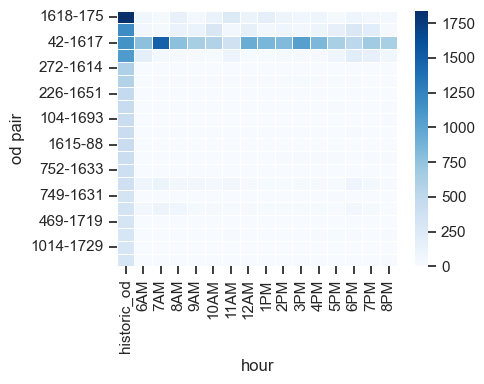

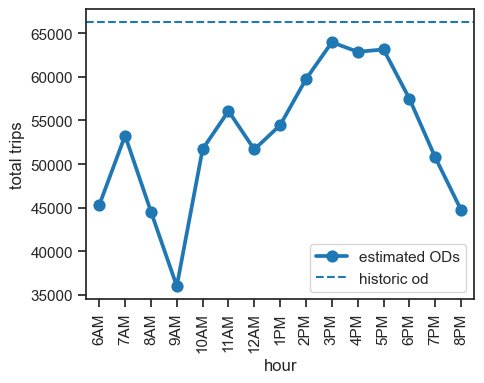

In [38]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          reference_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True, rotation_xticks = 90)

In [39]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.6433196, 'tt_sd': -2.1362135, 'median_inc': 0.1550856, 'incidents': -4.128349, 'bus_stops': -0.12513824, 'intersections': -3.0036342}
kappa= {'population': 108.11519, 'income': 24.07735, 'bus_stops': -34.13095}
Avg abs diff of observed and estimated OD:  12.53
Avg observed OD:  9.51


### TVODLULPE

In [30]:
# To report runtime
t0 = time.time()

models['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods,
                                                    reference_q = flat_od_from_generated_trips(reference_g, ods = network.ods),
                                                    # reference_q = reference_q,
                                                    features_Z = _FEATURES_Z, dtype = _DTYPE)

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS['tvodlulpe'],
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS['tvodlulpe'],
    loss_metric= _LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['tvodlulpe'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvodlulpe'].save_weights(f"output/models/{ts}_fresno_tvodlulpe.h5")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      30  mdape
1  traveltime      40  mdape
0        flow 5.8e+05    mse
1  traveltime   0.066    mse
0        flow  -0.044     r2
1  traveltime -0.0004     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 15, batch size: 1, threshold relative gap: inf
training set -> timepoints: 225, obs [t x]: [2081.  140.], coverage [t x]: [0.86 0.06]
validation set -> timepoints: 195, obs [t x]: [2151.  140.], coverage [t x]: [0.89 0.06]

Learning stage: 20 epochs

0/20: train mse=1.8e+06, train mse traveltime=2e+02, train mdape traveltime=17.8 train mse flow=5.2e+06, train mdape flow=67.1, val mse=1.9e+06, val mse traveltime=1.9e+02, val mdape traveltime=16.7 val mse flow=5.4e+06, val mdape flow

KeyboardInterrupt: 

In [31]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                     mape  mdape      mse        r2
component   dataset                                      
equilibrium training   8.49e+07   1.82 1.44e+05     0.902
            validation 8.73e+16   2.95 9.82e+04     0.933
flow        benchmark      67.7   30.3 5.77e+05    -0.044
            training        131   65.4 4.57e+06     -6.44
            validation      126   66.9 4.65e+06     -7.15
traveltime  benchmark      55.7   40.3   0.0658 -0.000404
            training        142   16.7     16.1      -230
            validation      136     16     14.9      -231


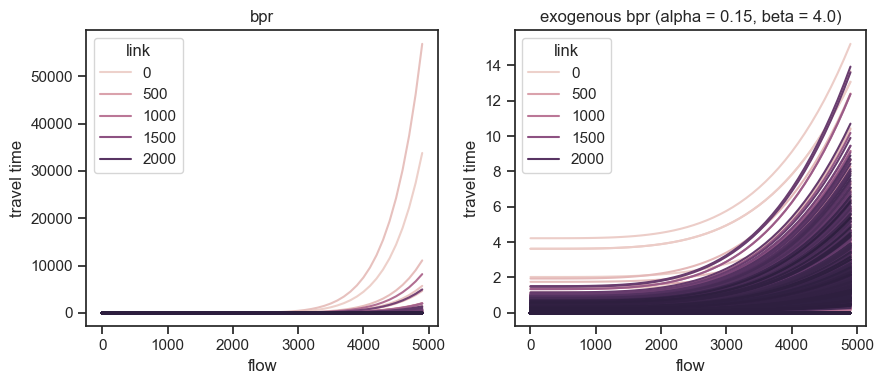

In [42]:
flow_range = range(0,5000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

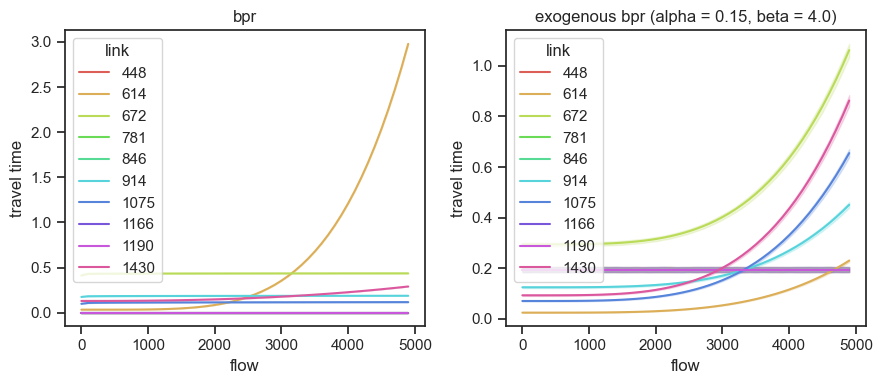

In [43]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

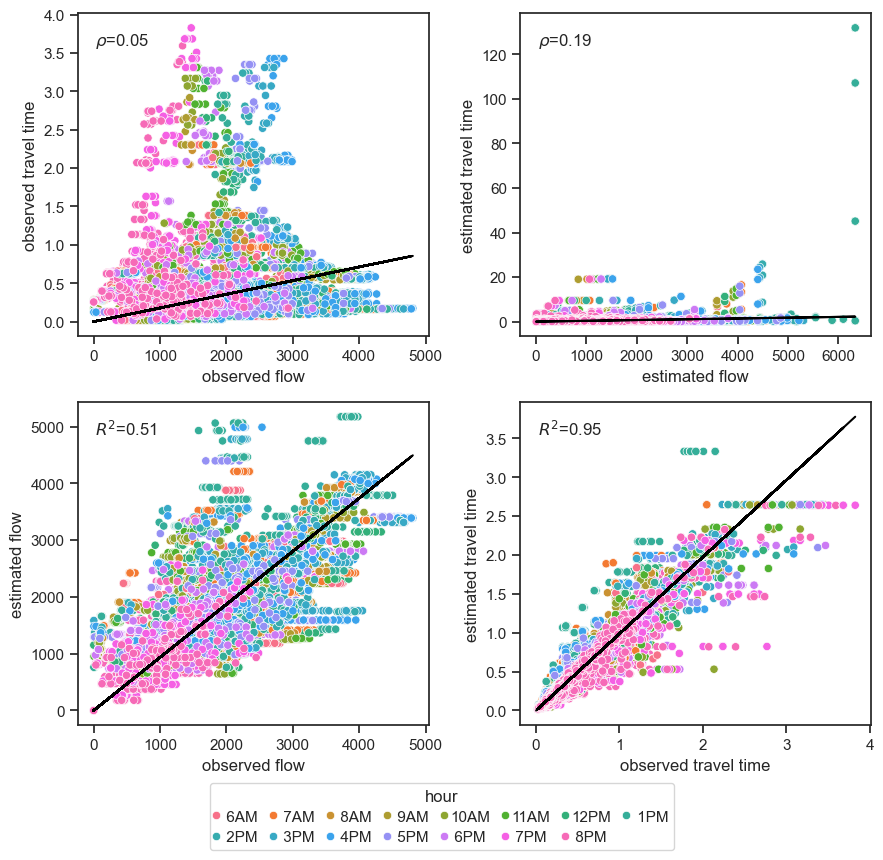

In [44]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

plt.show()

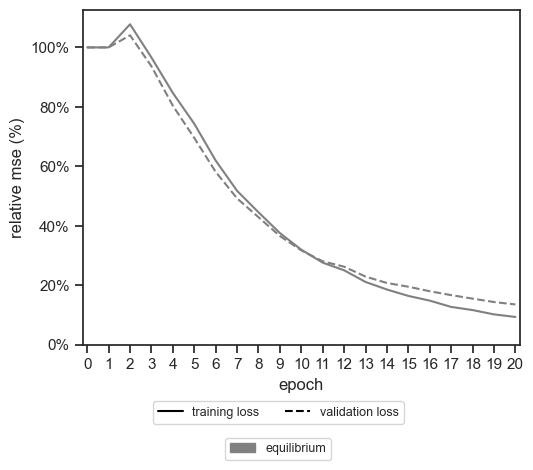

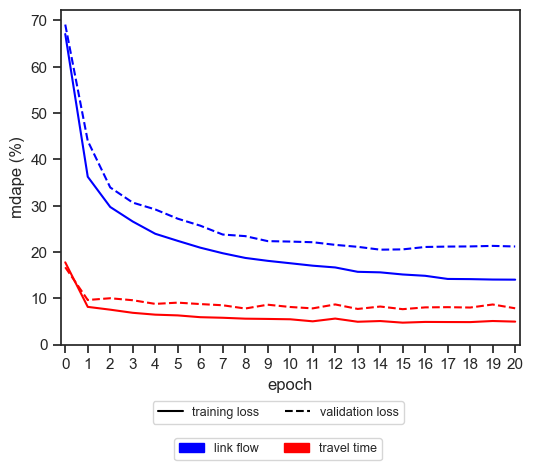

In [45]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['equilibrium'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['travel time', 'link flow'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

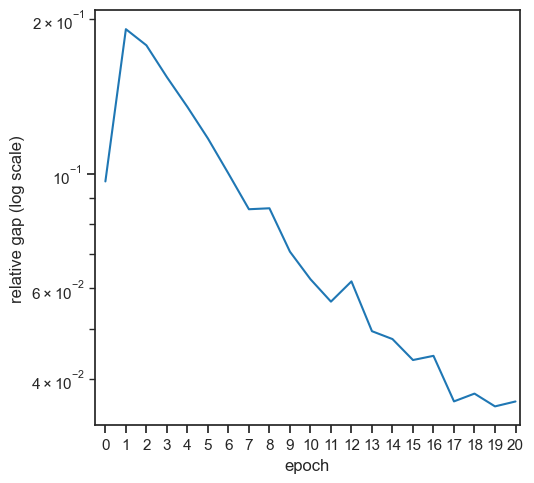

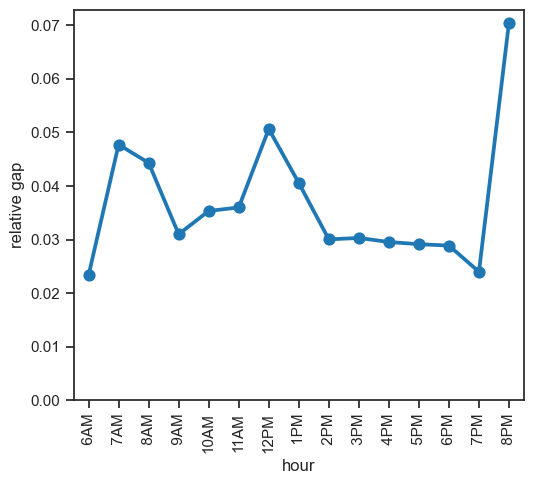

In [46]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

plot_relative_gap_by_period(model = models['tvodlulpe'], period_keys = period_keys)

plt.savefig('output/figures/results/fresno-relative-gap-period-tvodlulpe.png')

plt.show()

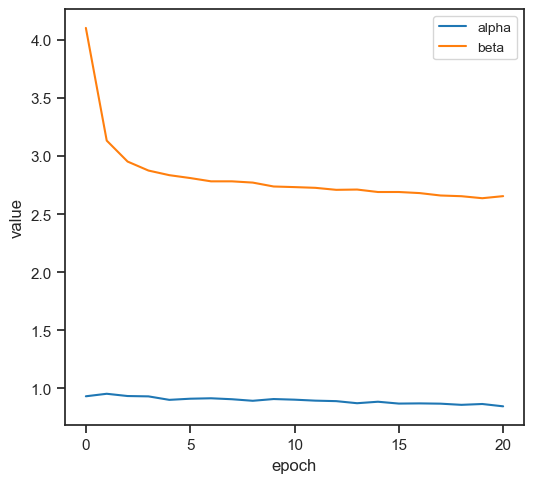

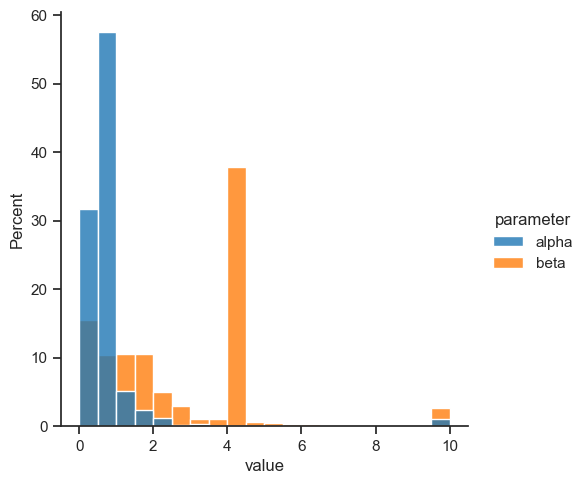

In [47]:
if models['tvodlulpe'].performance_function.type == 'bpr':

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=5)
    plt.show()

    #sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

    plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                                  'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
    # sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

    try:
        sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)
        plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')
        plt.show()
    except:
        print('Distribution plot could not be shown')

             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
6-7   -4.096901  0.000000     0.00000  -4.273395   0.000000      -2.320472   
7-8   -3.551709 -2.154223     0.00000  -3.873812   0.000000      -2.299991   
8-9   -2.980808 -1.826699     0.00000  -4.230922   0.000000      -3.320003   
9-10  -3.882428 -3.314829     0.00000  -3.997825   0.000000      -2.296766   
10-11 -2.997698 -2.502333     0.00000  -4.253287   0.000000      -3.258391   
11-12 -2.907153 -2.954698     0.64242  -4.642875   0.000000      -2.366940   
12-13 -3.675428 -2.463610     0.00000  -3.552739   0.000000      -2.764293   
13-14 -3.834728 -0.683541     0.00000  -4.423588   0.000000      -3.086756   
14-15 -3.127404 -3.400672     0.00000  -4.176398   0.000000      -3.596332   
15-16 -3.183529 -1.305195     0.00000  -4.139717  -1.525668      -3.028184   
16-17 -4.082513  0.000000     0.00000  -4.155904   0.000000      -3.248366   
17-18 -4.120465 -1.323846     0.00000  -4.713570   0.000000     

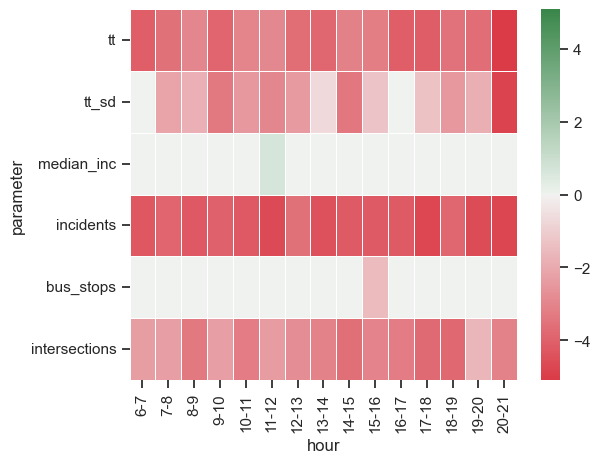

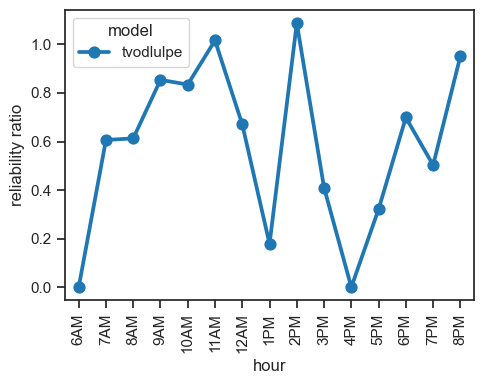

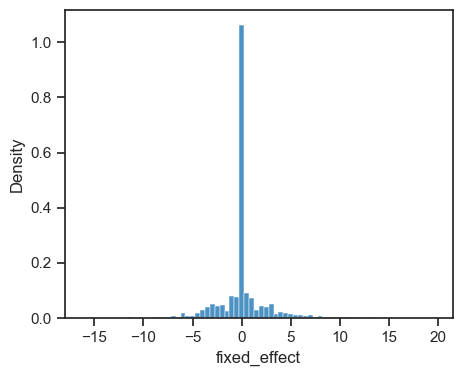

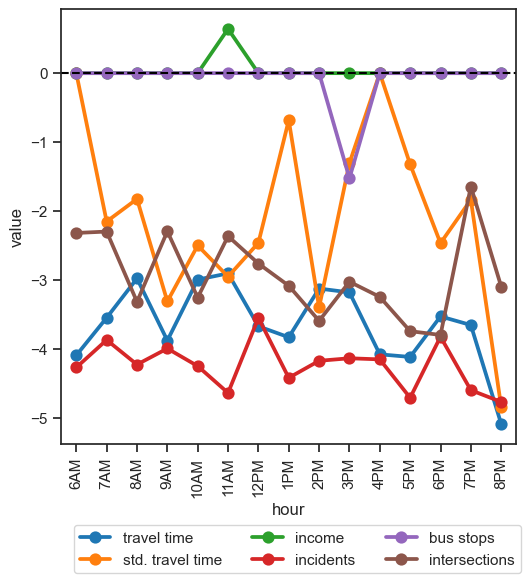

In [48]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour', rotation_xticks = 90)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (5.55,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:879: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od           6AM           7AM           8AM  \
 1618 175     1840.4001  1.546399e+02  1.630858e+02  1.778068e+02   
      694     1182.4533  2.613076e+02  2.559449e+02  3.198906e+02   
 42   1617    1139.6952  6.248524e+02  6.245183e+02  5.730345e+02   
 693  1617    1077.8859  8.065997e+02  8.691577e+02  7.184460e+02   
 272  1614     598.5315  2.176811e-18  4.105938e-12  1.598225e-17   
 701  1629     577.9746  6.336600e-01  4.542915e-01  1.337051e+00   
 226  1651     472.3362  8.860484e-05  6.278746e-04  7.574759e-05   
 220  1688     446.1534  1.195846e-03  3.513231e-05  5.102215e-03   
 104  1693     430.1766  8.581363e-02  7.280388e-03  9.428529e-03   
 871  1679     428.9796  6.772242e+00  2.754915e+00  2.738123e-01   
 1615 88       426.7179  9.695040e+00  2.959088e+00  1.234493e+00   
 807  1650     418.2822  5.415290e-04  1.132847e-03  3.541571e-05   
 752  1633     392.5845  7.437608e-30  3.154181e-19  0.000000e+00   
 42   88       386.4609  1.656237e

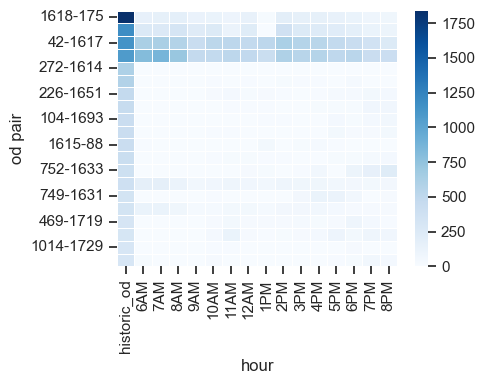

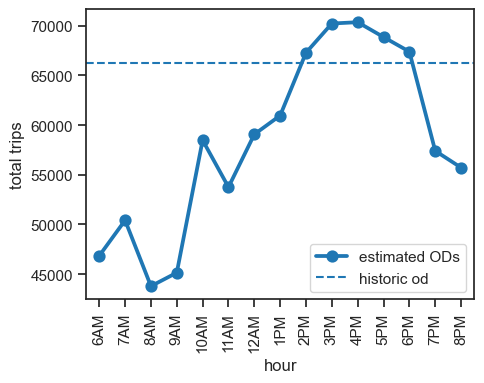

In [49]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          reference_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True,
                          rotation_xticks = 90)

In [50]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.6481774, 'tt_sd': -2.0720785, 'median_inc': 0.042827986, 'incidents': -4.242485, 'bus_stops': -0.10171122, 'intersections': -2.925264}
alpha =  0.85, beta  =  2.65
Avg abs diff of observed and estimated OD:  12.20
Avg observed OD:  9.51


## Write estimation results

In [51]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 231219220843_train_results_fresno.csv was written
File 231219220843_validation_results_fresno.csv was written


## Summary of parameter estimates

### All models

In [52]:
models

{'tvgodlulpe': <nesuelogit.models.NESUELOGIT at 0x34c244ee0>,
 'tvodlulpe': <nesuelogit.models.NESUELOGIT at 0x32f097640>}

In [53]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [54]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

model              tvgodlulpe  tvodlulpe
parameter                               
tt                    -3.6433    -3.6482
tt_sd                 -2.1362    -2.0721
median_inc             0.1551     0.0428
incidents             -4.1283    -4.2425
bus_stops             -0.1251    -0.1017
intersections         -3.0036    -2.9253
rr                     0.5863     0.5680
fixed_effect_mean      0.0080     0.0571
fixed_effect_std       2.8713     2.6606
od_mean                7.6117     8.3746
od_std                33.1954    30.1510
alpha_mean                NaN     0.8463
alpha_std                 NaN     1.0853
beta_mean                 NaN     2.6546
beta_std                  NaN     2.0636


### TVGODLULPE

In [55]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

theta:        0       1       2       3       4       5       6       7       8   \
0 -4.1411 -3.3555 -2.7728 -2.8032 -3.5449 -2.6547 -2.9932 -3.0210 -2.8079   
1  0.0000  0.0000 -2.9953 -2.9817  0.0000  0.0000 -2.7841 -3.0469 -3.0820   
2  0.0000  0.0000  0.2513  0.2899  0.0000  0.0000  0.2694  0.2756  0.3197   
3 -3.6912 -2.2931 -4.6311 -4.6699 -2.6058 -4.1740 -3.5006 -4.5383 -4.3552   
4  0.0000  0.0000  0.0000  0.0000 -1.8771  0.0000  0.0000  0.0000  0.0000   
5 -2.7687 -2.2208 -2.7464 -2.7274 -2.5818 -2.7185 -2.8414 -2.9697 -3.6668   

       9       10      11      12      13      14  
0 -2.7003 -3.5156 -5.1231 -3.6487 -5.3436 -6.2242  
1 -1.3423 -0.2092 -1.3737 -5.0281 -4.1056 -5.0942  
2  0.0000  0.3932  0.0000  0.0000  0.0000  0.5272  
3 -3.1655 -5.0280 -5.3906 -4.0470 -5.2875 -4.5475  
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
5 -2.8343 -3.3773 -3.2581 -3.2005 -3.7841 -3.3587  


In [56]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

kappa:         0        1        2        3        4        5        6        7   \
0 110.7568 129.1216 111.8320  99.0147  99.7680 102.7748 110.9459 117.9624   
1  25.6655  28.0931  24.7819  22.2075  21.9441  23.5535  24.1400  25.6158   
2 -36.3046 -38.3973 -34.3447 -30.4968 -30.8666 -33.6300 -33.3529 -35.9274   

        8        9        10       11       12       13       14  
0 129.1474 136.5228 134.7841 117.9568  89.5916  71.1321  60.4170  
1  27.9302  29.3669  29.3219  26.2158  20.9760  17.1929  14.1551  
2 -39.6771 -40.8147 -41.6740 -38.7737 -31.1687 -25.3388 -21.1970  


In [57]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

OD matrix                  0          1          2          3          4          5   \
od_mean      6.4983     7.6429     6.3925     5.1655     7.4200     8.0462   
od_std      32.9083    31.9516    30.1129    27.3915    29.6181    33.0334   
od_total 45293.4219 53270.7812 44555.8203 36003.4844 51717.3125 56081.8242   

                 6          7          8          9          10         11  \
od_mean      7.4144     7.8140     8.5719     9.1776     9.0208     9.0586   
od_std      31.4472    32.8619    37.2051    35.5564    36.5521    36.7715   
od_total 51678.4609 54463.5000 59745.8203 63968.1641 62875.3008 63138.7109   

                 12         13         14  
od_mean      8.2503     7.2842     6.4188  
od_std      36.1781    34.0388    30.1372  
od_total 57504.6953 50770.7344 44739.1250  


## Summary of models goodness of fit

In [58]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS[model_key]['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [59]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

         model  epoch  loss_traveltime               loss_od  loss_theta  \
15  tvgodlulpe     15         -99.9420                   NaN         NaN   
20   tvodlulpe     20         -99.9983 2431802046210259.0000         NaN   

    loss_flow  loss_equilibrium  loss_bpr  loss_ntrips          loss_prop_od  \
15   -87.0709          -93.7606       NaN          NaN                   NaN   
20   -94.2956          -90.6838       NaN          NaN 1456330519991890.2500   

    loss_regularizer_kernel  loss_regularizer_utility_ods  \
15                      NaN                           NaN   
20                      NaN                           NaN   

    loss_regularizer_od  loss_total  relative_gap       model  
15                  NaN    -87.0300        0.0482  tvgodlulpe  
20                  NaN    -94.2659        0.0362   tvodlulpe  


## Plot of convergence toward true rr across models

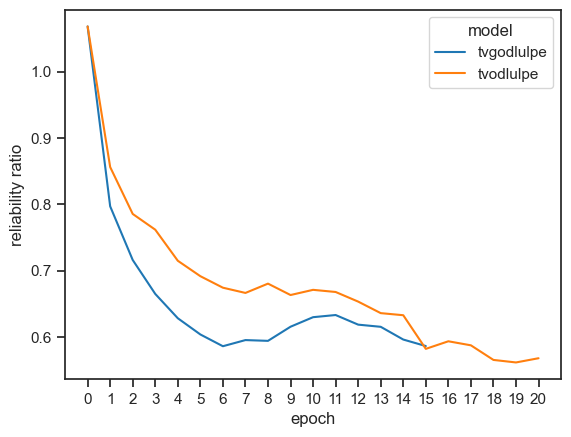

In [60]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, 1))

plt.show()

## Plot of reliability ratio by hour for all models

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:945: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=rr_by_hour_models, x=period_feature + '_id', y="rr", ax=ax,


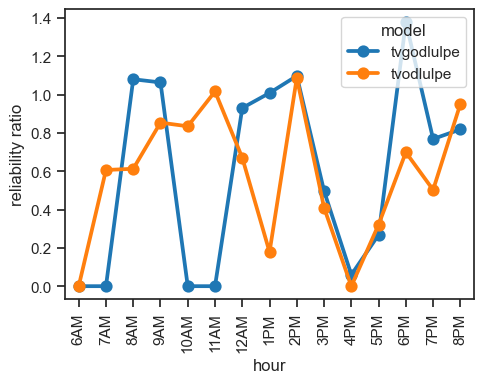

In [61]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [62]:
print(reliability_ratios)

          rr  hour hour_id       model
0  -0.000000     6     6AM  tvgodlulpe
1  -0.000000     6     6AM   tvodlulpe
2  -0.000000     7     7AM  tvgodlulpe
3   0.606531     7     7AM   tvodlulpe
4   1.080252     8     8AM  tvgodlulpe
5   0.612820     8     8AM   tvodlulpe
6   1.063680     9     9AM  tvgodlulpe
7   0.853803     9     9AM   tvodlulpe
8  -0.000000    10    10AM  tvgodlulpe
9   0.834752    10    10AM   tvodlulpe
10 -0.000000    11    11AM  tvgodlulpe
11  1.016354    11    11AM   tvodlulpe
12  0.930147    12    12AM  tvgodlulpe
13  0.670292    12    12AM   tvodlulpe
14  1.008561    13     1PM  tvgodlulpe
15  0.178250    13     1PM   tvodlulpe
16  1.087379    14     2PM   tvodlulpe
17  1.097633    14     2PM  tvgodlulpe
18  0.497102    15     3PM  tvgodlulpe
19  0.409984    15     3PM   tvodlulpe
20 -0.000000    16     4PM   tvodlulpe
21  0.059496    16     4PM  tvgodlulpe
22  0.321286    17     5PM   tvodlulpe
23  0.268136    17     5PM  tvgodlulpe
24  0.698957    18     6P

In [63]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

          0       2      4      6       8       10      12      14      17  \
hour  6.0000  7.0000 8.0000 9.0000 10.0000 11.0000 12.0000 13.0000 14.0000   
rr   -0.0000 -0.0000 1.0803 1.0637 -0.0000 -0.0000  0.9301  1.0086  1.0976   

          18      21      23      25      27      28  
hour 15.0000 16.0000 17.0000 18.0000 19.0000 20.0000  
rr    0.4971  0.0595  0.2681  1.3781  0.7683  0.8184  


In [64]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

               rr
model            
tvgodlulpe  0.598
tvodlulpe   0.583


## Plot of total trips by hour for all models

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:1025: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data= total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax,


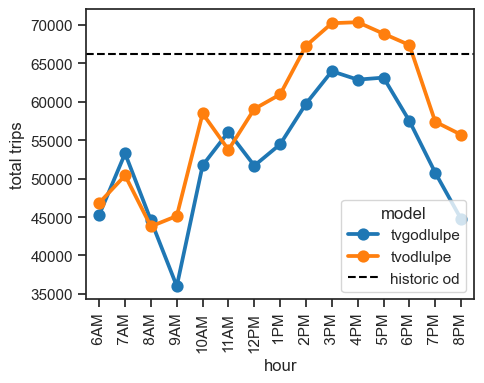

In [65]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      reference_od = network.q.flatten(), join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [66]:
print(total_trips)

    hour   total_trips       model  order
0    6AM  45293.425781  tvgodlulpe      6
0    6AM  46836.339844   tvodlulpe      6
1    7AM  53270.808594  tvgodlulpe      7
1    7AM  50410.363281   tvodlulpe      7
2    8AM  44555.812500  tvgodlulpe      8
2    8AM  43779.343750   tvodlulpe      8
3    9AM  36003.519531  tvgodlulpe      9
3    9AM  45136.699219   tvodlulpe      9
4   10AM  51717.421875  tvgodlulpe     10
4   10AM  58468.671875   tvodlulpe     10
5   11AM  56081.816406  tvgodlulpe     11
5   11AM  53747.718750   tvodlulpe     11
6   12PM  51678.429688  tvgodlulpe     12
6   12PM  59060.425781   tvodlulpe     12
7    1PM  54463.480469  tvgodlulpe     13
7    1PM  60954.636719   tvodlulpe     13
8    2PM  67276.687500   tvodlulpe     14
8    2PM  59745.835938  tvgodlulpe     14
9    3PM  63968.226562  tvgodlulpe     15
9    3PM  70214.734375   tvodlulpe     15
10   4PM  70346.460938   tvodlulpe     16
10   4PM  62875.339844  tvgodlulpe     16
11   5PM  68849.515625   tvodlulpe

In [67]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

,total_trips
model,
tvgodlulpe,53053.800781
tvodlulpe,58371.199219


In [68]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

,total_trips
model,
tvgodlulpe,795807.3125
tvodlulpe,875567.6250


## Comparison of tvgodlulpe against historical mean

In [69]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin(_HOURS)) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

_ = models['tvgodlulpe'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC}, X=XT_val, Y=YT_val)

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=models['tvgodlulpe'], model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis',
                                           benchmark_model = 'historical_mean')

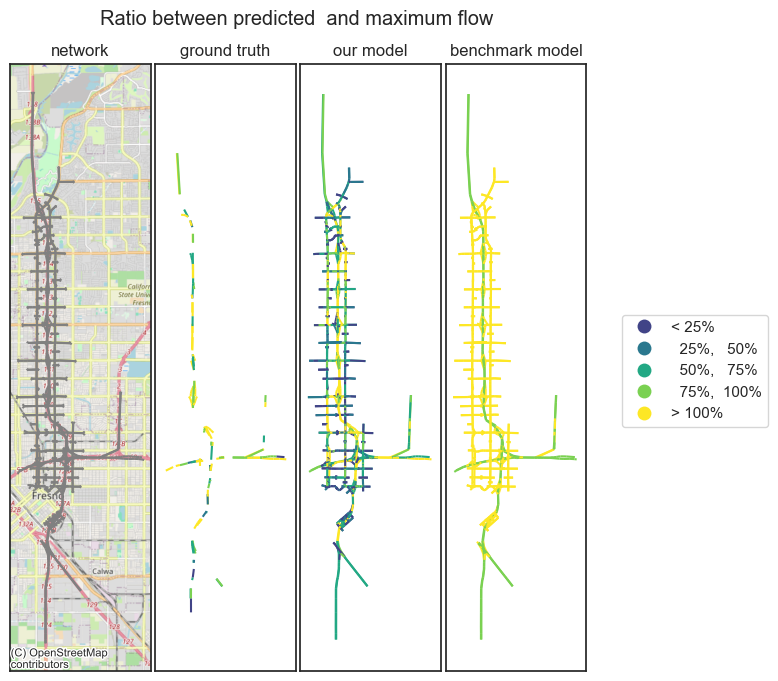

In [70]:
fig_flow

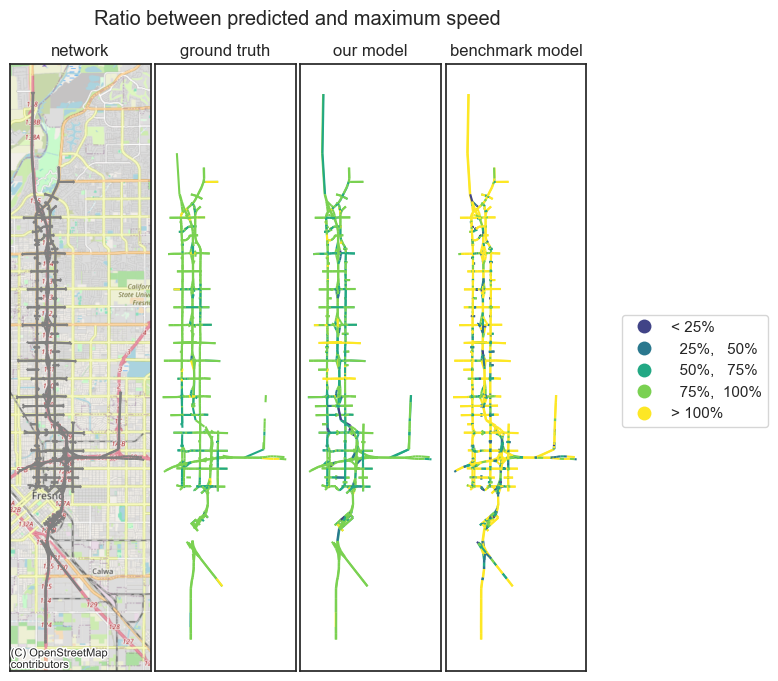

In [71]:
fig_speed



## Global runtime

In [72]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 25918.0 [s]
